# Code-modulated visual evoked potentials (c-VEP)
This notebook shows the preprocessing and analysis of the c-VEP dataset. Note, we made available three runs with the following data:
- task-train1: 32 trials with a shifted m-sequence
- task-train2: 10 trials with a set of Gold codes
- task-train3: 32 trials with a shifted m-sequence (similar to task-train1)

During the experiment, we also ran free-spelling runs. For these runs however, we do not have ground-truth labels. Additionally, during these runs, a dynamic stopping procedure was ran, which has a consequence that these free-spelling trials have a varying trial-duration. All this makes these runs overly complicated for offline analysis. Thus, we focus on the training runs only, as these contain well-defined ground-truth labels and trials that were always of a length of 4.2 seconds. 

In [1]:
import os
import h5py
import numpy as np
import mne
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.cross_decomposition import CCA
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from scipy.interpolate import griddata
from matplotlib.patches import Circle, Ellipse, Polygon
import matplotlib.pyplot as plt
import seaborn
seaborn.set_context("paper")


In [2]:
# Path to the dataset
path = "/Users/u829215/Downloads/mant_ms_bids"
subject = "VPpdfb"
session = "ses-20230223"
task = "task-train1"  # task-train1, task-train2, task-train3


## Read and preprocess data
In the code snippet below, we preprocess the c-VEP EEG data. It follows the following steps:
1. Read the continuous EEG data.
1. Apply a pass-band spectral filter. Note, this is an evoked paradigm, meaning the band can be relatively low.
1. Slice the trials from the continuous data. Note, there was a marker at the start of every trial. Also note, that we need to clean-up some erroneous markers, unfortunately.
1. Downsample the data. Note, this is done on the sliced data, which introduces edge effects at the start of a trial. Please, observe that a window of 500 ms is sliced before trial-onset, such that the edge effects end up in the pre-trial period, which we can cut away.

Subsequently, we read the labels from a Matlab file that was produced during the experiment. Normally, this label information is in the markers as well, which is not the case here.

Finally, we read the stimuli that were presented, as we need these for the analysis later on. Note that the stimuli were presented at the monitor refresh rate (60 Hz). To use them in the analysis, they are upsampled to the EEG sample frequency. 

In [3]:
# Parameters
fs = 240  # target sample frequency
tmin = 0  # start of a trial
tmax = 4.2  # end of a trial
l_freq = 2  # high-pass cut-off
h_freq = 30  # low-pass cut-off

# Read raw file
fn = os.path.join(path, subject, session, "eeg", f"{subject}_{session}_{task}_eeg.gdf")
raw = mne.io.read_raw_gdf(fn, stim_channel="status", preload=True)

# Spectral band-pass filter
raw.filter(l_freq=l_freq, h_freq=h_freq, picks="eeg")

# Read events
events = mne.find_events(raw)

# Select only the start of a trial
# N.B. Need to cleanup some wrongly inserted markers
cond = np.diff(events[:, 0]) / raw.info['sfreq'] > 2
idx = np.concatenate(([0], 1 + np.where(cond)[0]))
if task == "task-train1":
    idx = idx[1:]
onsets = events[idx, :]

# Slice data to trials
epo = mne.Epochs(raw, events=onsets, tmin=tmin-0.5, tmax=tmax, baseline=None, picks="eeg", preload=True)

# Downsample
# N.B. Done on trial to maintain best timing accuracy. Edge artefacts will end up in 500 ms pre-trial.
epo.resample(sfreq=fs)

# Extract data
X = epo.get_data()[:, :64, int(0.5 * fs):]
print("X:", X.shape)


Extracting EDF parameters from /Users/u829215/Downloads/mant_ms_bids/VPpdfb/ses-20230223/eeg/VPpdfb_ses-20230223_task-train1_eeg.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
Fp1, AF7, AF3, F1, F3, F5, F7, FT7, FC5, FC3, FC1, C1, C3, C5, T7, TP7, CP5, CP3, CP1, P1, P3, P5, P7, P9, PO7, PO3, O1, Iz, Oz, POz, Pz, CPz, Fpz, Fp2, AF8, AF4, AFz, Fz, F2, F4, F6, F8, FT8, FC6, FC4, FC2, FCz, Cz, C2, C4, C6, T8, TP8, CP6, CP4, CP2, P2, P4, P6, P8, P10, PO8, PO4, O2, EXG1, EXG2, EXG3, EXG4, EXG5, EXG6, EXG7, EXG8, ANA1, ANA2, ANA3, ANA4, ANA5, ANA6, ANA7, ANA8, ANA9, ANA10, ANA11, ANA12, ANA13, ANA14, ANA15, ANA16, ANA17, ANA18, ANA19, ANA20, ANA21, ANA22, ANA23, ANA24, ANA25, ANA26, ANA27, ANA28, ANA29, ANA30, ANA31, ANA32
Creating raw.info structure...
Reading 0 ... 100889  =      0.000 ...   197.049 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 30 Hz

FI

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


34 events found
Event IDs: [257]
Not setting metadata
32 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 32 events and 2407 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=1)]: Done 104 out of 104 | elapsed:    0.3s finished


X: (32, 64, 1008)


Text(0.5, 1.0, 'Single-trial multi-channel EEG time-series (trial 0)')

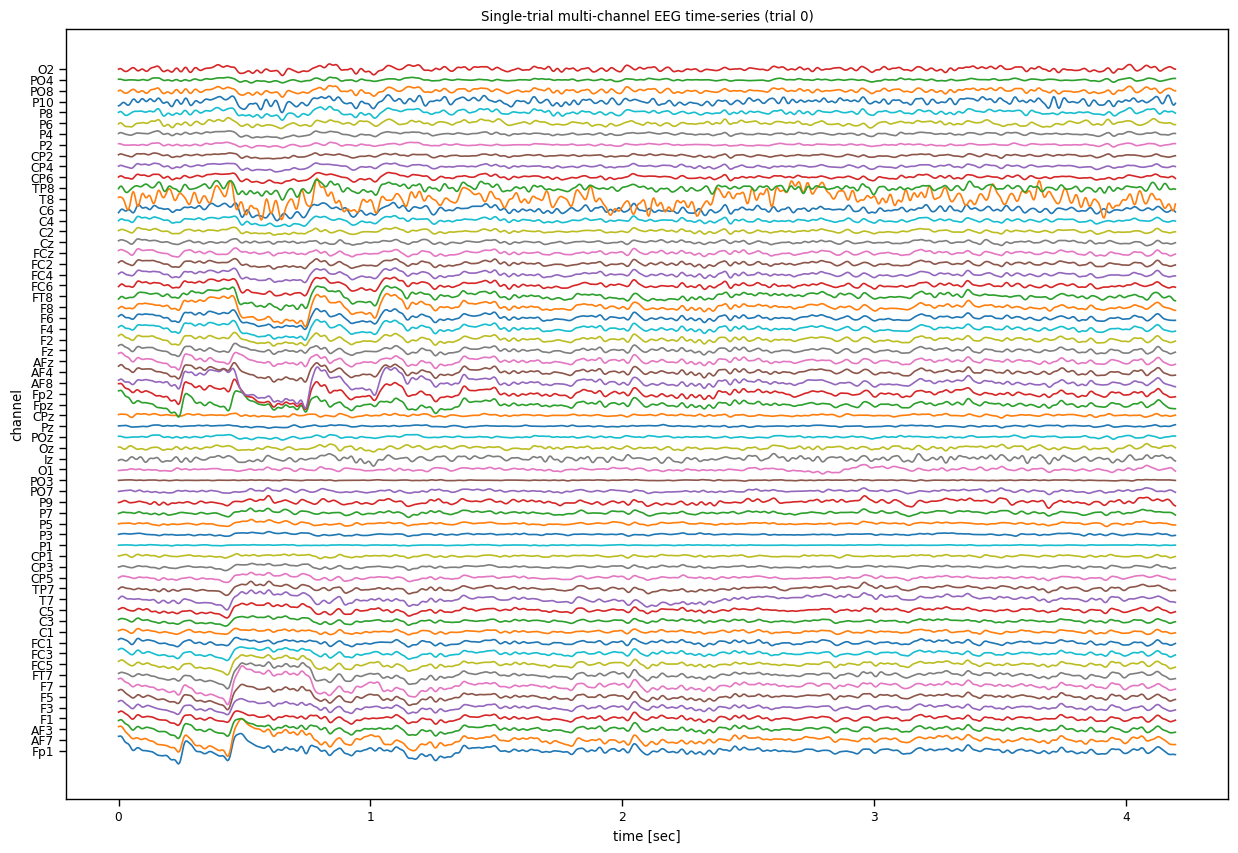

In [4]:
# Visualize EEG data
i_trial = 0
plt.figure(figsize=(15, 10))
plt.plot(np.arange(0, X.shape[2]) / fs, 25e-6 * np.arange(X.shape[1]) + X[i_trial, :, :].T)
plt.yticks(25e-6 * np.arange(X.shape[1]), epo.info["ch_names"][:64])
plt.xlabel("time [sec]")
plt.ylabel("channel")
plt.title(f"Single-trial multi-channel EEG time-series (trial {i_trial})")


y: (32,)


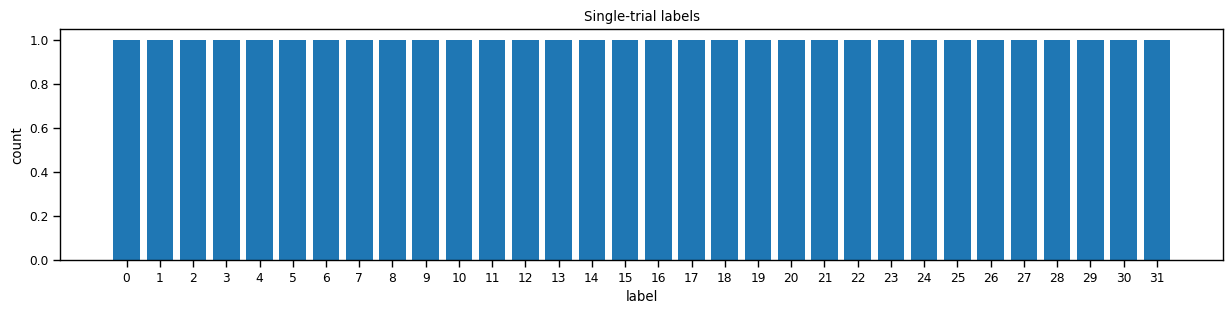

In [5]:
# Read labels
# N.B. Minus 1 to convert Matlab counting from 1 to Python counting from 0
fn = os.path.join(path, subject, session, "eeg", f"{subject}_{session}_{task}_labels.mat")
y = np.array(h5py.File(fn, "r")["v"]).astype("uint8").flatten() - 1
print("y:", y.shape)

# Visualize labels
plt.figure(figsize=(15, 3))
hist = np.histogram(y, bins=np.arange(np.unique(y).size+1))[0]
plt.bar(np.arange(np.unique(y).size), hist)
plt.xticks(np.arange(np.unique(y).size))
plt.xlabel("label")
plt.ylabel("count")
plt.title("Single-trial labels");


V: (1008, 32)


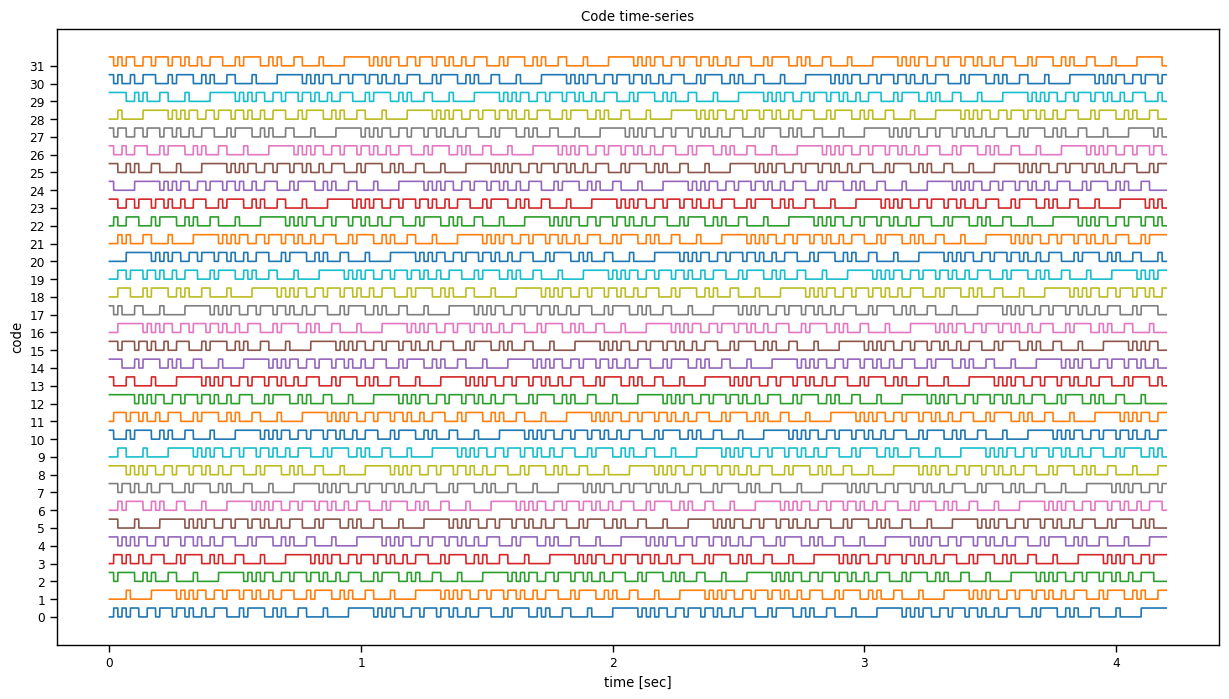

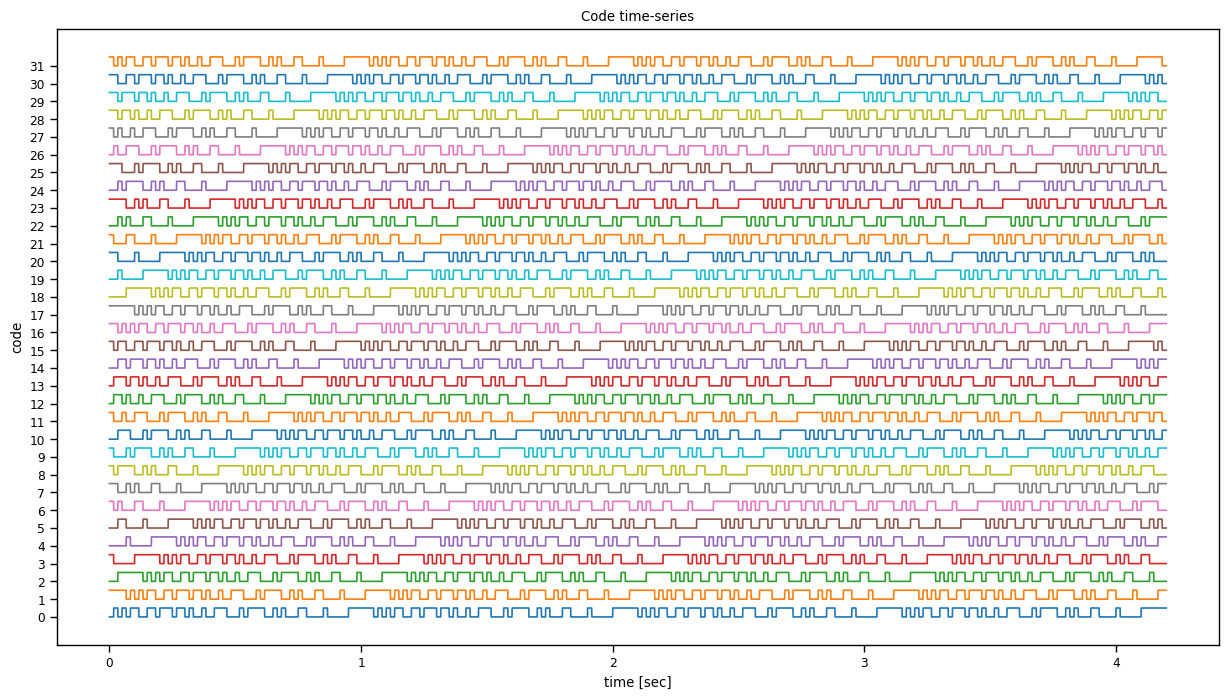

In [6]:
# Read codes
# N.B. Upsample codes from screen framerate to EEG sampling rate
fr = 60 # monitor refresh rate
fn = os.path.join(path, subject, session, "eeg", f"{subject}_{session}_{task}_stims.mat")
V = np.array(h5py.File(fn, "r")["v"]).astype("uint8")
V = np.repeat(V, fs // fr, axis=0).astype("uint8")
print("V:", V.shape)

# Visualize codes
codes = V.repeat(20, axis=0)  # upsample to better visualize the sharp edges
plt.figure(figsize=(15, 8))
plt.plot(np.arange(0, codes.shape[0]) / (20 * fs), 2 * np.arange(codes.shape[1]) + codes)
plt.yticks(2 * np.arange(codes.shape[1]), np.arange(codes.shape[1]))
plt.xlabel("time [sec]")
plt.ylabel("code")
plt.title("Code time-series");

# Visualize codes
# N.B. reshuffle to visualize the circular shifting of the m-sequence
# N.B. only for train1 and train3 (m-sequence), not for train2 (Gold codes)
if task == "task-train1" or task == "task_train2":
    codes = V.reshape(-1, 4, 8).transpose(0, 2, 1).reshape(-1, 32)
    codes = codes.repeat(20, axis=0)  # upsample to better visualize the sharp edges
    plt.figure(figsize=(15, 8))
    plt.plot(np.arange(0, codes.shape[0]) / (20 * fs), 2 * np.arange(np.unique(y).size) + codes)
    plt.yticks(2 * np.arange(np.unique(y).size), np.arange(np.unique(y).size))
    plt.xlabel("time [sec]")
    plt.ylabel("code")
    plt.title("Code time-series");


## Helper functions and classes
The function below define a simplified version of the 'reconvolution' model as introduced and used in the following publications:
- Thielen, J., van den Broek, P., Farquhar, J., & Desain, P. (2015). Broad-Band visually evoked potentials: re (con) volution in brain-computer interfacing. PloS one, 10(7), e0133797.
- Thielen, J., Marsman, P., Farquhar, J., & Desain, P. (2017). Re (con) volution: accurate response prediction for broad-band evoked potentials-based brain computer interfaces. Brain-Computer Interface Research: A State-of-the-Art Summary 6, 35-42.
- Thielen, J., Marsman, P., Farquhar, J., & Desain, P. (2021). From full calibration to zero training for a code-modulated visual evoked potentials for brain–computer interface. Journal of Neural Engineering, 18(5), 056007.

This model makes use of canonical correlation analysis (CCA) to decompose the c-VEP responses into a spatial as well as a temporal filter. Specifically, it assumes that the response to a sequence of events (e.g., flashes) is the summation of the responses to the individual events (i.e., the linear supperposition hypothesis). Note, what an event is can be defined by the researcher. Quite typically, we use a 'duration' event, such that for every flash-duration a separate response is learned. Instead, one could also use a 'contrast' event that learns the response to an on-flank and off-flank of a flash, regardless of the duration of the flash. 


In [7]:
def topoplot(z, capfile, cbar=False, ax=None):
    """
    Plots a topoplot given the values at each electrode and an electrode
    position file.
    
    Args:
        z (numpy.ndarray): 
            A vector of electrode values, e.g. a spatial 
            filter/patterns.
        capfile (str): 
            A text file with electrode position information.
        cbar (bool): 
            Whether or not to add a colorbar. 
            Default: False
        ax (matplotlib.axes.Axes): 
            Axes to plot in. A new one is made when None.
            Default: None
    """
    
    # Read electrode positions
    with open(capfile) as fid:
        lines = fid.read().split("\n")
        xy = np.zeros((len(lines), 2))
        for i, line in enumerate(lines):
            __, t, r, __ = line.split("\t")
            t = (float(t) + 90) / 180 * np.pi
            r = float(r) * 2
            xy[i, :] = r*np.cos(t), r*np.sin(t)
            
    # Add additional points for interpolation to edge of head
    edge = np.array([[-1, -1], [-1, 1], [1, -1], [1, 1]])
    xy = np.concatenate((xy, edge), axis=0)
    z = np.concatenate((z, np.zeros((4,))), axis=None)

    # Make grid
    N = 300
    xi = np.linspace(-2, 2, N)
    yi = np.linspace(-2, 2, N)
    zi = griddata((xy[:, 0], xy[:, 1]), z, (xi[None,:], yi[:,None]), 
        method="cubic", fill_value="nan")

    # Set points outside radius to nan so they will not be plotted.
    d = xi[1] - xi[0]
    for i in range(N):
        for j in range(N):
            if np.sqrt(xi[i]**2 + yi[j]**2) + d > 1.1:
                zi[j, i] = "nan"

    # Make figure
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111, aspect=1)
    
    # Add head
    circle = Circle(xy=[0,0], radius=1, edgecolor="k", facecolor="None", zorder=2)
    ax.add_patch(circle)

    # Add ears
    circle = Ellipse(xy=[-1,0], width=0.25, height=0.5, angle=0, edgecolor="k", 
        facecolor="None", zorder=0)
    ax.add_patch(circle)
    circle = Ellipse(xy=[1,0], width=0.25, height=0.5, angle=0, edgecolor="k", 
        facecolor="None", zorder=0)
    ax.add_patch(circle)

    # Add a nose
    polygon = Polygon(xy=[[-0.1,0.9], [0,1.25],[0.1,0.9]], edgecolor="k", 
        facecolor="None", zorder=1)
    ax.add_patch(polygon) 

    # Add the interpolated data
    cs = ax.contourf(xi, yi, zi, 60, cmap=plt.cm.RdYlBu_r, zorder=1)
    
    # Add iso-lines
    #ax.contour(xi, yi, zi, 15, colors="grey", zorder=3)

    # Add data points
    ax.scatter(xy[:-4,0], xy[:-4,1], marker="o", c="k", s=15, zorder=4)
    
    # Add color bar
    if cbar:
        fig.colorbar(cs, ax=ax)

    # Make the axis invisible 
    ax.axis("off")

    # set axes limits
    ax.set_xlim(1.25, -1.25)
    ax.set_ylim(-1.05, 1.4)
    ax.set_aspect(1.0)
    

In [8]:
def correlation(A, B):
    """
    Compute the correlation coefficient between two sets of variables.
    Note, equivalent to: 
    rho = np.corrcoef(A.T, B.T)[:A.shape[1]:, A.shape[1]:], but faster.

    Args:
        A (numpy.ndarray): 
            The first set of variables of shape (n_A, n_samples).
        B (numpy.ndarray): 
            The second set of variables of shape (n_B, n_samples).

    Returns:
        (numpy.ndarray): 
            The correlation matrix of shape (n_A, n_B).
    """

    # Demean
    A -= np.mean(A, axis=1, keepdims=True)
    B -= np.mean(B, axis=1, keepdims=True)

    # Sum of squares
    ssA = np.sum(A**2, axis=1)
    ssB = np.sum(B**2, axis=1)

    # Correlation coefficient
    outer = np.dot(ssA[:, np.newaxis], ssB[np.newaxis, :])
    score = np.dot(A, B.T) / np.sqrt(outer)

    return score


In [9]:
def event_matrix(V, event, onset_event=False):
    """
    Translate codes to events.

    Args:
        V (numpy.ndarray): 
            The noise-tags (i.e., pseudo-random noise-codes) used for 
            stimulation of shape (n_samples, n_codes). Note, should be 
            sampled at fs! Note, one code-repetition is sufficient!
        event (str): 
            The event type to perform the transformation of codes to 
            events with:
                dur: "duration": each run-length of ones is an event 
                    (e.g., 1, 11, 111, etc.)
                re: "rising edge": each 0 to 1 transition is an event 
                    (i.e., 01)
                fe: "falling edge": each 1 to 0 transition is an event 
                    (i.e., 10)
                refe: "rising edge falling edge" or "contrast": one 
                    event for re and one for fe (i.e., 01 and 10)
        onset_event (bool): 
            Whether or not to model the onset of stimulation. 
            Default: False

    Returns:
        (numpy.ndarray): 
            An event matrix of zeros and ones denoting the onsets of 
            events of shape (n_events, n_samples, n_codes).
        (tuple): 
            A tuple of event descriptors.
    """

    V = V.astype("bool_")
    n_samples, n_codes = V.shape

    if (event == "dur" or 
        event == "duration"):

        # Get rising and falling edges
        Vr = np.roll(V, 1, axis=0)
        Vr[0, :] = False
        rise = np.logical_and(V, np.logical_not(Vr))
        fall = np.logical_and(np.logical_not(V), Vr)

        # Create event dictionary
        E = dict()
        for i_code in range(n_codes):

            # Get rising and falling edge locations
            up = np.where(rise[:, i_code])[0]
            down = np.where(fall[:, i_code])[0]
            if up.size > down.size:
                down = np.append(down, n_samples)

            # Get durations of events
            durations = down - up
            unique_durations = np.unique(durations)

            # Fill out durations in dictionary
            for duration in unique_durations:
                if duration not in E:
                    E[duration] = np.zeros((n_samples, n_codes), dtype="bool_")
                E[duration][up, i_code] = durations == duration

        # Extract unique events (sorted numerically or alphabetically)
        events = tuple(sorted(E.keys()))

        # Convert dictionary to event matrix
        E = np.array([E[duration] for duration in events]).astype("bool_")

    elif (event == "re" or 
          event == "risingedge" or 
          event == "rise"):
        # Get falling edges
        Vr = np.roll(V, 1, axis=0)
        Vr[0, :] = False
        E = np.logical_and(V, np.logical_not(Vr))[np.newaxis, ...]
        events = ("rise",)

    elif (event == "fe" or 
          event == "fallingedge" or 
          event == "fall"):
        # Get rising edges
        Vr = np.roll(V, 1, axis=0)
        Vr[0, :] = False
        E = np.logical_and(np.logical_not(V), Vr)[np.newaxis, ...]
        events = ("fall",)

    elif (event == "refe" or 
          event == "risingfallingedge" or 
          event == "contrast"):
        # Get rising edges
        Vr = np.roll(V, 1, axis=0)
        Vr[0, :] = False
        rise = np.logical_and(V, np.logical_not(Vr))
        fall = np.logical_and(np.logical_not(V), Vr)
        E = np.concatenate((rise[np.newaxis, ...], fall[np.newaxis, ...]), 
            axis=0)
        events = ("rise", "fall")

    else:
        raise Exception(f"Unknown event: {event}.")

    # Add onset response
    if onset_event:
        E = np.concatenate((E, np.zeros((1, n_samples, n_codes))), axis=0)
        E[-1, 0, :] = 1
        events += ("onset",)

    return E, events


In [10]:
def structure_matrix(E, transient_size):
    """
    Translate events to structure matrices.

    Args:
        E (numpy.ndarray): 
            An event matrix of zeros and ones denoting the onsets of 
            events of shape (n_events, n_samples, n_codes).
        transient_size (float, list): 
            The length of the transient response to fit for all (int) 
            or each of the (list) events in seconds. 

    Returns:
        (numpy.ndarray): 
            The structure matrix denoting event timings of shape 
            (transient_size, n_samples, n_codes).
    """

    n_events, n_samples, n_codes = E.shape

    if isinstance(transient_size, int):
        transient_size = n_events * [transient_size]
    elif (isinstance(transient_size, list) or 
          isinstance(transient_size, tuple)):
        assert len(transient_size) == n_events, (
            "len(transient_size) does not match E.shape[0].")
    else:
        raise Exception("transient_size should be (int, list, tuple).")

    # Create structure matrix
    M = []
    for i_event in range(n_events):
        tmp = np.zeros((transient_size[i_event], n_samples, n_codes), 
            dtype="uint8")
        tmp[0, :, :] = E[i_event, :, :]
        for i_sample in range(1, transient_size[i_event]):
            tmp[i_sample, :, :] = np.roll(tmp[i_sample-1, :, :], 1, axis=0)
            tmp[i_sample, 0, :] = 0
        M.append(tmp)

    # Concatenate structure matrices
    M = np.concatenate(M, axis=0).astype("uint8")

    return M


In [11]:
class rCCA(BaseEstimator, ClassifierMixin):
    """
    The 'reconvolution CCA', which performs a spatial and temporal 
    decomposition (reconvolution) within a CCA to perform spatial
    filtering as well as template prediction. 

    References:
    * Thielen et al. (2015) doi: 10.1371/journal.pone.0133797
    * Thielen et al. (2017) doi: 10.1007/978-3-319-64373-1_4
    * Thielen et al. (2021) doi: 10.1088/1741-2552/abecef
    """

    def __init__(self, codes, fs, event="duration", transient_size=0.3, 
            onset_event=False, score_metric="correlation", latency=None):
        """
        Constructor for rCCA.

        Args:
            codes (numpy.ndarray): 
                The pseudo-random noise-codes used for stimulation of 
                shape (n_samples, n_codes). Should be sampled at fs and 
                one code-repetition is sufficient. 
            fs (int): 
                The EEG data sampling frequency.
            event (str): 
                The event type to perform the transformation of codes to
                events with. 
                Default: "duration"
            transient_size (float, list): 
                The length of the transient response(s) for each of the 
                events in seconds. 
                Default: 0.3
            onset_event (bool):
                Whether or not to add an event for the onset of 
                stimulation. Added as last event.
                Default: False
                
        """
        self.codes = codes
        self.fs = fs
        self.event = event
        self.transient_size = transient_size
        self.onset_event = onset_event

    def _apply_w(self, X):
        """
        Apply spatial filter to data to obtain spatially filtered data.

        Args:
            X (numpy.ndarray): 
                The matrix of EEG data of shape (n_trials, n_channels, 
                n_samples).

        Returns
            (numpy.ndarray): 
                The spatially filtered EEG data of shape (n_trials, 
                n_samples).
        """
        n_trials, n_channels, n_samples = X.shape
        X = np.transpose(X, (1, 0, 2))
        X = np.reshape(X, (n_channels, n_trials * n_samples))
        X = np.dot(self.w_, X)
        X = np.reshape(X, (n_trials, n_samples))
        return X

    def _apply_r(self, n_samples):
        """
        Perform (discrete) convolution of a structure matrix with a 
        response vector to obtain predicted responses (i.e., templates).

        Args:
            n_samples (int):
                The number of samples that the templates should be.

        Returns:
            (numpy.ndarray): 
                The predicted templates of shape (n_codes, n_samples).
        """
        M = self._get_M(n_samples)
        transient_size, n_samples, n_codes = M.shape
        M = np.reshape(M, (transient_size, n_samples * n_codes))
        T = np.dot(self.r_, M)
        T = np.reshape(T, (n_samples, n_codes)).T
        return T

    def _fit_w_r(self, X, y):
        """
        Perform (discrete) deconvolution of EEG data into a spatial 
        filter and event-responses according to a structure matrix using
        canonical correlation analysis (CCA).

        Args:
            X (numpy.ndarray): 
                The matrix of EEG data of shape (n_channels, n_samples, 
                n_trials).
            y (numpy.ndarray): 
                The vector of ground-truth labels of the trials in X of 
                shape (n_trials). Note, these denote the index at which
                to find the associated codes! 

        Returns:
            (numpy.ndarray): 
                The spatial filter of shape (n_channels).
            (numpy.ndarray): 
                The response vector containing the (concatenated) 
                transient response(s) for each of the events of shape 
                (transient_size).
        """
        n_trials, n_channels, n_samples = X.shape

        # Reshape the structure matrix (i.e., concatenate all trials)
        M = self._get_M(n_samples)
        M = np.reshape(M[:, :, y], (M.shape[0], n_samples * n_trials)).T

        # Reshape the EEG data (i.e., concatenate all trials)
        X = np.transpose(X, (1, 2, 0))
        X = np.reshape(X, (n_channels, n_samples * n_trials)).T

        # Fit CCA
        cca = CCA(n_components=1).fit(X, M)
        w = cca.x_weights_.flatten()
        r = cca.y_weights_.flatten()
        return w, r

    def _get_M(self, n_samples):
        """
        Get the structure matrix of a particular length.

        Args:
            n_samples (int):
                The number of samples that the structure matrix should 
                be.

        Returns:
            (numpy.ndarray): 
                The structure matrix denoting event timings of shape 
                (transient_size, n_samples, n_codes).
        """
        # Repeat the codes to n_samples
        if self.codes.shape[0] != n_samples:
            n = int(np.ceil(n_samples / self.codes.shape[0]))
            codes = np.tile(self.codes, (n, 1))[:n_samples, :]
        else:
            codes = self.codes

        # Get structure matrices
        E, self.events_ = event_matrix(codes, self.event, self.onset_event)
        M = structure_matrix(E, int(self.transient_size * self.fs))
        return M

    def _get_T(self):
        """
        Get the templates.

        Returns:
            (numpy.ndarray):
                The templates of shape (n_samples, n_codes) for the 
                start of a trial.
            (numpy.ndarray):
                The templates of shape (n_samples, n_codes) for 
                repetitions within a trial.
        """
        n_samples = self.codes.shape[0]
        T = self._apply_r(2 * n_samples)
        Ts = T[:, :n_samples]
        Tw = T[:, n_samples:]
        return Ts, Tw

    def fit(self, X, y):
        """
        The training procedure to fit a rCCA on supervised EEG data. 

        Args:
            X (numpy.ndarray): 
                The matrix of EEG data of shape (n_trials, n_channels, 
                n_samples).
            y (numpy.ndarray): 
                The vector of ground-truth labels of the trials in X of 
                shape (n_trials). Note, these denote the index at which 
                to find the associated codes! 

        Returns:
            (rCCA):
                Returns itself.
        """
        X, y = check_X_y(X, y, ensure_2d=False, allow_nd=True, 
            y_numeric=True)
        y = y.astype(np.uint)

        # Fit w and r
        self.w_, self.r_ = self._fit_w_r(X, y)

        # Set templates (start and wrapper)
        self.Ts_, self.Tw_ = self._get_T()

        return self

    def predict(self, X):
        """
        The testing procedure to apply rCCA to novel EEG data.

        Args:
            X (numpy.ndarray): 
                The matrix of EEG data of shape (n_trials, n_channels, 
                n_samples).

        Returns:
            (numpy.ndarray): 
                The vector of predicted labels of the trials in X of 
                shape (n_trials). Note, these denote the index at which 
                to find the associated codes! 
        """
        check_is_fitted(self, ["w_", "r_", "Ts_", "Tw_"])
        X = check_array(X, ensure_2d=False, allow_nd=True)
        n_samples = X.shape[2]

        # Spatially filter data
        X = self._apply_w(X)

        # Set templates to trial length
        if self.Ts_.shape[1] != n_samples:
            n = int(np.ceil(n_samples / self.Ts_.shape[1]))
            if (n - 1) > 1:
                Tw = np.tile(self.Tw_, (1, (n - 1)))
            else:
                Tw = self.Tw_
            T = np.concatenate((self.Ts_, Tw), axis=1)[:, :n_samples]
        else:
            T = self.Ts_

        # Classification
        self.score_ = correlation(X, T)
        yh = np.argmax(self.score_, axis=1)
        return yh

    def set_codes(self, codes):
        """
        Set the codes and as such change the templates.

        Args
            codes (numpy.ndarray): 
                The pseudo-random noise-codes used for stimulation of 
                shape (n_samples, n_codes). Should be sampled at fs and 
                one code-repetition is sufficient. 
        """
        self.codes = codes
        self.Ts_, self.Tw_ = self._get_T()


## Reconvolution
Reconvolution decomposes the response to a sequence of events (i.e., a c-VEP) into the responses to the individual events (i.e., transient responses). This is done by constructing event time-series that list when specific events occur in the bit-sequences.

E: shape: (6, 252, 32) , type: float64
Events: (4, 8, 12, 16, 24, 'onset')


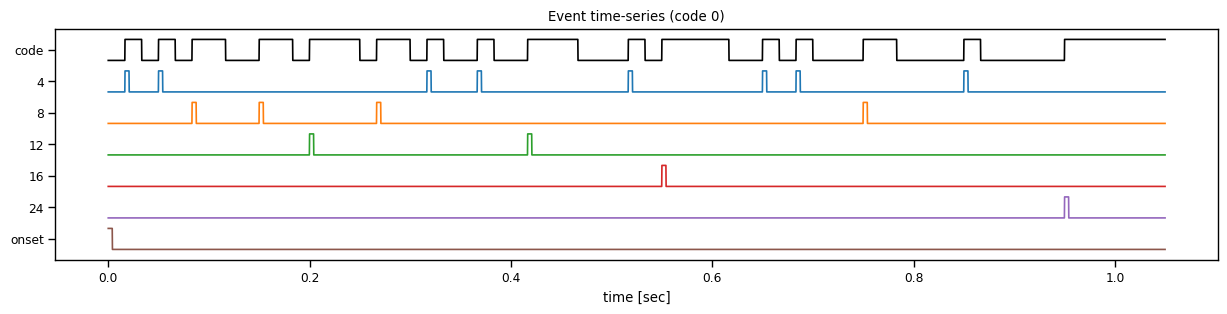

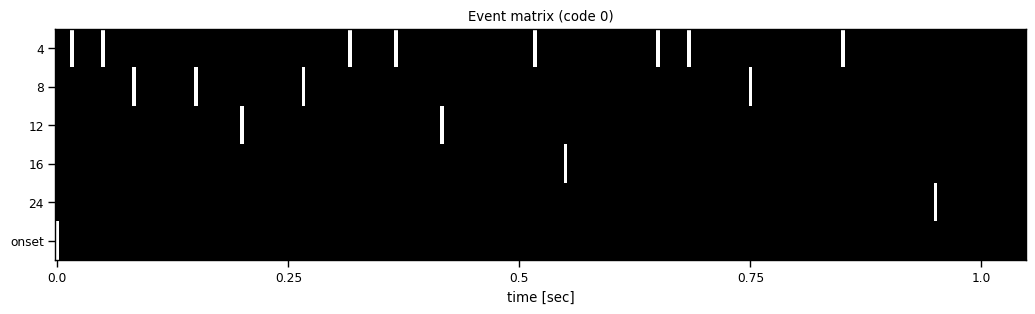

In [12]:
# Get events (of 1 code cycle)
n_samples = int(fs * 1.05)
E, events = event_matrix(V[:n_samples, :], event="duration", onset_event=True)

print("E: shape:", E.shape, ", type:", E.dtype)
print("Events:", events)

# Visualize event time-series
i_class = 0
Vu = V[:n_samples, :].repeat(20, axis=0)  # upsample to better visualize the sharp edges
Eu = E.repeat(20, axis=1)  # upsample to better visualize the sharp edges
plt.figure(figsize=(15, 3))
plt.plot(np.arange(0, Vu.shape[0]) / (20*fs), Vu[:, i_class], "k")
for i in range(E.shape[0]):
    plt.plot(np.arange(0, Eu.shape[1]) / (20*fs), -1.5 * (1 + i) + Eu[i, :, i_class])
plt.yticks(-1.5 * np.arange(0, 1 + E.shape[0]) + 0.5, ("code",) + events)
plt.xlabel("time [sec]")
plt.ylabel("")
plt.title(f"Event time-series (code {i_class})");

# Visualize event matrix
i_code = 0
plt.figure(figsize=(15, 3))
plt.imshow(E[:, :, i_code], cmap="gray")
plt.gca().set_aspect(10)
plt.xticks(np.arange(0, n_samples, 60), np.arange(0, n_samples, 60) / fs)
plt.yticks(np.arange(E.shape[0]), events)
plt.xlabel("time [sec]")
plt.title(f"Event matrix (code {i_code})");


## Cross-validation
Here we set up a simple chronological cross-validation to estimate a decoding performance. The model is calibrated on the data in the training folds, and applied to the data in the testing folds. 

Please note that this dataset contains only one trial per class, or even fewer. This implies that the reconvolution model needs to generalize to codes that it has never seen during training. Specifically, as it is a template-matching classifier, it needs to generate expected templates for codes it has never seen. Moreover, it will need to do so given only a very limited training dataset!

Accuracy: avg=0.97 with std=0.08


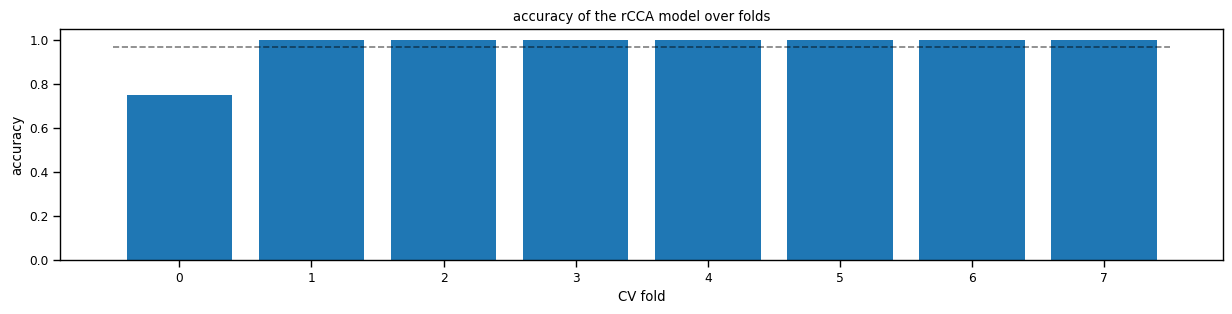

In [13]:
# Parameters
event = "contrast"
transient_size = 0.3
onset_event = True

# Set folds
# N.B. n_folds needs to fit the number of trials: train1 and train3 have 32 trials, train2 only 10
if task == "task-train2":
    n_folds = 5
else:
    n_folds = 8
folds = np.repeat(np.arange(n_folds), int(X.shape[0] / n_folds))

# Cross-validation
accuracy = np.zeros(n_folds)
for i_fold in range(n_folds):
    
    # Split data to train and valid set
    X_trn, y_trn = X[folds != i_fold, ...], y[folds != i_fold]
    X_tst, y_tst = X[folds == i_fold, ...], y[folds == i_fold]
    
    # Train template-matching classifier
    rcca = rCCA(codes=V, fs=fs, event=event, transient_size=transient_size, onset_event=onset_event)
    rcca.fit(X_trn, y_trn)
    
    # Apply template-matching classifier
    yh_tst = rcca.predict(X_tst)
        
    # Compute accuracy
    accuracy[i_fold] = np.mean(yh_tst == y_tst)
    
# Plot accuracy (over folds)
plt.figure(figsize=(15, 3))
plt.bar(np.arange(n_folds), accuracy)
plt.hlines(np.mean(accuracy), -.5, n_folds-0.5, linestyle='--', color="k", alpha=0.5)
plt.xlabel("CV fold")
plt.ylabel("accuracy")
plt.title("accuracy of the rCCA model over folds");

# Print accuracy (average and standard deviation over folds)
print(f"Accuracy: avg={accuracy.mean():.2f} with std={accuracy.std():.2f}")


## Inspect the model
As mentioned, reconvolution learns both a temporal as well as a spatial filter. The code snippet below visualizes what the model has learned.

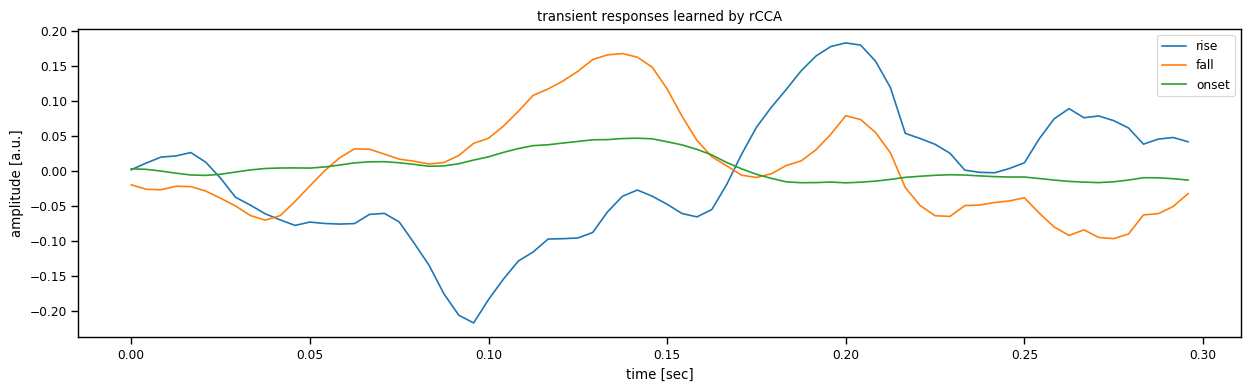

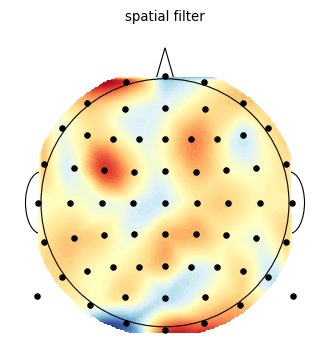

In [14]:
# Parameters
event = "contrast"
transient_size = 0.3
onset_event = True

# Train a model on all data
rcca = rCCA(codes=V, fs=fs, event=event, transient_size=transient_size, onset_event=onset_event)
rcca.fit(X, y)

# Plot transient responses
plt.figure(figsize=(15, 4))
for i_event, event in enumerate(rcca.events_):
    start = int(i_event * rcca.transient_size * fs)
    length = int(rcca.transient_size * fs)
    plt.plot(np.arange(length) / fs, rcca.r_[start:start + length], label=event)
plt.legend()
plt.xlabel("time [sec]")
plt.ylabel("amplitude [a.u.]")
plt.title("transient responses learned by rCCA");

# Plot spatial filter
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
topoplot(rcca.w_, "biosemi_cap64.loc", ax=ax)
plt.title("spatial filter");
